In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *

In [3]:
from words import *

In [4]:
MAX_LEN = 15

In [5]:
languages = ['en', 'de', 'fr', 'it', 'sp']
filepaths = get_filepaths(*languages)
df = read_data(filepaths)
df = filter_data(df, min_len=4, max_len=MAX_LEN, min_freq=5)
feats = extract_features(df)

In [6]:
df.head()

,word,freq,language
37,wurde,1463,deu
46,sich,1066,deu
47,eine,1049,deu
53,auch,662,deu
55,nach,653,deu


In [7]:
feats.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,language
37,w,u,r,d,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deu
46,s,i,c,h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deu
47,e,i,n,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deu
53,a,u,c,h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deu
55,n,a,c,h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deu


In [8]:
def gen_dummy_cols():
    for i in range(MAX_LEN):
        for c_i in range(ord('a'), ord('z') + 1):
            c = chr(c_i)
            yield f'{i}_{c}'
        yield f'{i}_nan'

dummy_cols = list(gen_dummy_cols())

In [9]:
y = feats['language']
y_dummy = pd.get_dummies(y)
y_dummy = y_dummy.astype(np.float32).reset_index(drop=True)

In [10]:
feats_no_label = feats.drop('language', axis=1)

In [11]:
feats_dummy = pd.get_dummies(feats, dummy_na=True)
feats_dummy = feats_dummy.T.reindex(dummy_cols).T.fillna(0)
feats_dummy = feats_dummy.astype(np.float32).reset_index(drop=True)

In [12]:
feats_dummy.head()

,0_a,0_b,0_c,0_d,0_e,0_f,0_g,0_h,0_i,0_j,...,14_r,14_s,14_t,14_u,14_v,14_w,14_x,14_y,14_z,14_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
y_dummy.head()

,deu,eng,fra,ita,spa
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [14]:
n = feats.shape[0]
val_idxs = np.random.choice(n, int(n * 0.5), replace=False)

In [15]:
PATH = 'data/words/'
md = ColumnarModelData.from_data_frame(PATH, val_idxs, feats_dummy, y_dummy.values, cat_flds=[], bs=128,
                                       is_reg=False, is_multi=True)

In [16]:
learn = md.get_learner([], feats_dummy.shape[1], 0, 5, [500], [0.3])

In [17]:
learn.lr_find()

 19%|█▊        | 15/81 [00:00<00:00, 73.32it/s, loss=0.701]

/home/quentin/.virtualenvs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss                              
    0      0.940988   2.765062  



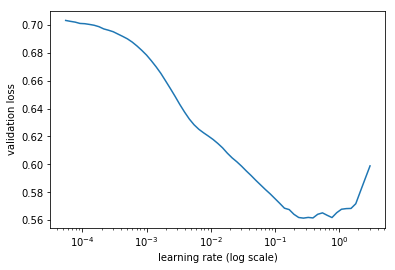

In [18]:
learn.sched.plot()

In [19]:
def acc(y_pred, targ):
    return np.array(y_pred.argmax(1) == targ.argmax(1)).mean()

In [20]:
learn.fit(0.1, 1, cycle_len=15, metrics=[acc])

epoch      trn_loss   val_loss   acc                        
    0      0.494744   0.442834   0.420925  
    1      0.461185   0.417289   0.468234                   
    2      0.423056   0.403452   0.507189                   
    3      0.398929   0.401934   0.500777                   
    4      0.374385   0.383459   0.540023                   
    5      0.349048   0.377575   0.540995                   
    6      0.328574   0.375891   0.561395                   
    7      0.308825   0.376121   0.570915                   
    8      0.295754   0.369043   0.576549                   
    9      0.280396   0.377037   0.579464                   
    10     0.264813   0.376209   0.586361                   
    11     0.255284   0.378973   0.591024                   
    12     0.248121   0.379935   0.588887                   
    13     0.240653   0.381046   0.591315                   
    14     0.238956   0.381442   0.591801                   



[0.3814415723021711, 0.5918010491548474]

In [21]:
preds = np.argmax(learn.predict_array([], feats_dummy.iloc[val_idxs]), axis=1)
preds.shape

(10294,)

In [22]:
labels = np.argmax(y_dummy.loc[val_idxs, :].values, axis=1)
labels.shape

(10294,)

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)

Confusion matrix, without normalization
[[1065  248  164   69   38]
 [ 155 1289  452  169  171]
 [ 107  403 1175  206  130]
 [  53  157  300 1376  386]
 [  51  199  270  474 1187]]


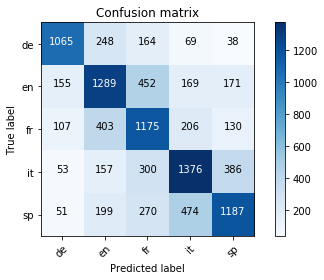

In [25]:
plot_confusion_matrix(cm, sorted(languages))

In [26]:
a = feats.iloc[val_idxs]
a['language'] = a.language.str.slice(0, 2)
a['pred'] = np.array(sorted(languages))[preds]

a['word'] = ''
for i in range(MAX_LEN):
     a['word'] += a[i].astype(str).replace('nan', '')
a = a.drop([i for i in range(MAX_LEN)], axis=1)
a = a[['word', 'language', 'pred']]

a.head(20)

/home/quentin/.virtualenvs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/quentin/.virtualenvs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/quentin/.virtualenvs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,word,language,pred
81586,imagen,sp,en
50152,variantes,fr,sp
85425,stuttgart,sp,de
1585,familien,de,fr
84923,esperaba,sp,sp
164939,pubblicare,it,it
160595,germania,it,sp
160111,hanno,it,it
124186,burn,en,en
161831,identita,it,en


In [27]:
a[a.pred == a.language].head(20)

,word,language,pred
84923,esperaba,sp,sp
164939,pubblicare,it,it
160111,hanno,it,it
124186,burn,en,en
85898,placas,sp,sp
49066,oncle,fr,fr
47288,obtenir,fr,fr
50521,dramatique,fr,fr
121199,according,en,en
46853,frere,fr,fr


In [28]:
a[a.pred != a.language].head(20)

,word,language,pred
81586,imagen,sp,en
50152,variantes,fr,sp
85425,stuttgart,sp,de
1585,familien,de,fr
160595,germania,it,sp
161831,identita,it,en
81500,sino,sp,it
47055,competition,fr,en
47112,resultat,fr,en
85319,france,sp,fr


In [29]:
data, y_idxs, _ = proc_df(feats, 'language')

In [30]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
37,23,21,18,4,5,0,0,0,0,0,0,0,0,0,0
46,19,9,3,8,0,0,0,0,0,0,0,0,0,0,0
47,5,9,14,5,0,0,0,0,0,0,0,0,0,0,0
53,1,21,3,8,0,0,0,0,0,0,0,0,0,0,0
55,14,1,3,8,0,0,0,0,0,0,0,0,0,0,0


In [31]:
y_dummy2 = np.zeros((len(y_idxs), 5))
y_dummy2[np.arange(len(y_idxs)), y_idxs] = 1

In [32]:
n = data.shape[0]
val_idxs = np.random.choice(n, int(n * 0.5), replace=False)

In [33]:
PATH = 'data/words/'
md = ColumnarModelData.from_data_frame(PATH, val_idxs, data, y_dummy2, cat_flds=list(range(MAX_LEN)), bs=128,
                                       is_reg=False, is_multi=True)

In [34]:
cat_sz = [(c, len(feats[c].cat.categories)+1) for c in list(range(MAX_LEN))]

In [35]:
cat_sz

[(0, 27),
 (1, 27),
 (2, 27),
 (3, 27),
 (4, 27),
 (5, 27),
 (6, 27),
 (7, 27),
 (8, 27),
 (9, 27),
 (10, 27),
 (11, 22),
 (12, 20),
 (13, 18),
 (14, 12)]

In [36]:
emb_szs = [(c, 13) for _,c in cat_sz]

In [37]:
learn = md.get_learner(emb_szs, 0, 0.4, 5, [500], [0.2])

In [38]:
learn.lr_find()

 75%|███████▌  | 61/81 [00:00<00:00, 76.98it/s, loss=0.567]


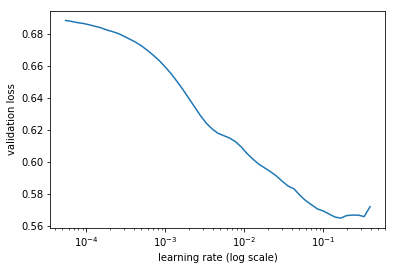

In [39]:
learn.sched.plot()

In [40]:
def acc(y_pred, targ):
    return np.array(y_pred.argmax(1) == targ.argmax(1)).mean()

In [41]:
learn.fit(0.01, 3, cycle_len=15, metrics=[acc])

epoch      trn_loss   val_loss   acc                        
    0      0.591212   0.470165   0.340198  
    1      0.459194   0.399112   0.500971                   
    2      0.416082   0.384009   0.514572                   
    3      0.394637   0.368289   0.561589                   
    4      0.377881   0.356937   0.568778                   
    5      0.366346   0.349895   0.588887                   
    6      0.357928   0.344975   0.589567                   
    7      0.347606   0.336701   0.607344                   
    8      0.341723   0.333526   0.611618                   
    9      0.3312     0.329754   0.61259                    
    10     0.324824   0.327065   0.619876                   
    11     0.321956   0.325651   0.623859                   
    12     0.315896   0.324748   0.621916                   
    13     0.310601   0.324855   0.62279                    
    14     0.308247   0.324789   0.623373                   
    15     0.340707   0.345156   0.59559 

[0.31439765356155375, 0.6418301923450553]

In [42]:
preds = np.argmax(learn.predict_array(data.iloc[val_idxs], []), axis=1)
preds.shape

(10294,)

In [43]:
labels = np.argmax(y_dummy2[val_idxs], axis=1)
labels.shape

(10294,)

Confusion matrix, without normalization
[[1040  199  159   55   43]
 [ 150 1390  534  109  135]
 [  75  353 1290  180  110]
 [  45  110  222 1610  313]
 [  41  169  210  475 1277]]


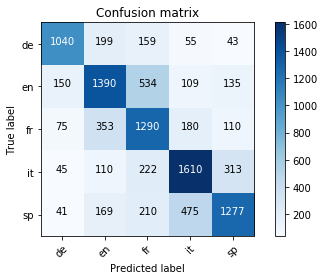

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, sorted(languages))

Normalized confusion matrix
[[0.69519 0.13302 0.10628 0.03676 0.02874]
 [0.06471 0.59965 0.23037 0.04702 0.05824]
 [0.03735 0.1758  0.64243 0.08964 0.05478]
 [0.01957 0.04783 0.09652 0.7     0.13609]
 [0.01888 0.07781 0.09669 0.21869 0.58794]]


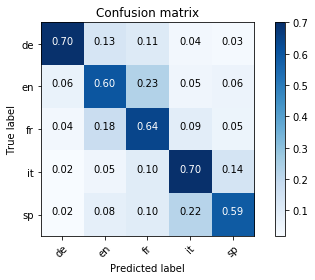

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, sorted(languages), normalize=True)